<a href="https://colab.research.google.com/github/bj-noh/lecture_nlp/blob/master/src/example/ResNet18_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
# MNIST 데이터셋 로드
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4631954.09it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 64631.73it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1271354.51it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3057869.79it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# DataLoader에 num_workers 추가하여 병렬 데이터 로드 활성화
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
# 사전 학습된 ResNet18 모델 불러오기
model_resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 202MB/s]


In [6]:
# 모델의 마지막 레이어 수정
num_features = model_resnet18.fc.in_features
model_resnet18.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 10),
    nn.LogSoftmax(dim=1)
)

In [7]:
# 모든 레이어를 고정 (학습되지 않도록 설정)
for param in model_resnet18.parameters():
    param.requires_grad = False

In [8]:
# 수정된 마지막 레이어만 학습되도록 설정
for param in model_resnet18.fc.parameters():
    param.requires_grad = True

In [9]:
# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_resnet18 = model_resnet18.to(device)

In [10]:
# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18.fc.parameters(), lr=0.001)

In [11]:
# 모델 훈련
num_epochs = 10
for epoch in range(num_epochs):
    model_resnet18.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

Epoch 1/10, Loss: 0.8734, Accuracy: 72.00%
Epoch 2/10, Loss: 0.6686, Accuracy: 78.15%
Epoch 3/10, Loss: 0.5989, Accuracy: 80.26%
Epoch 4/10, Loss: 0.5474, Accuracy: 82.02%
Epoch 5/10, Loss: 0.5194, Accuracy: 82.68%
Epoch 6/10, Loss: 0.4884, Accuracy: 83.81%
Epoch 7/10, Loss: 0.4703, Accuracy: 84.38%
Epoch 8/10, Loss: 0.4455, Accuracy: 85.15%
Epoch 9/10, Loss: 0.4243, Accuracy: 85.78%
Epoch 10/10, Loss: 0.4231, Accuracy: 85.73%


In [12]:
# 모델 평가
model_resnet18.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 84.59%


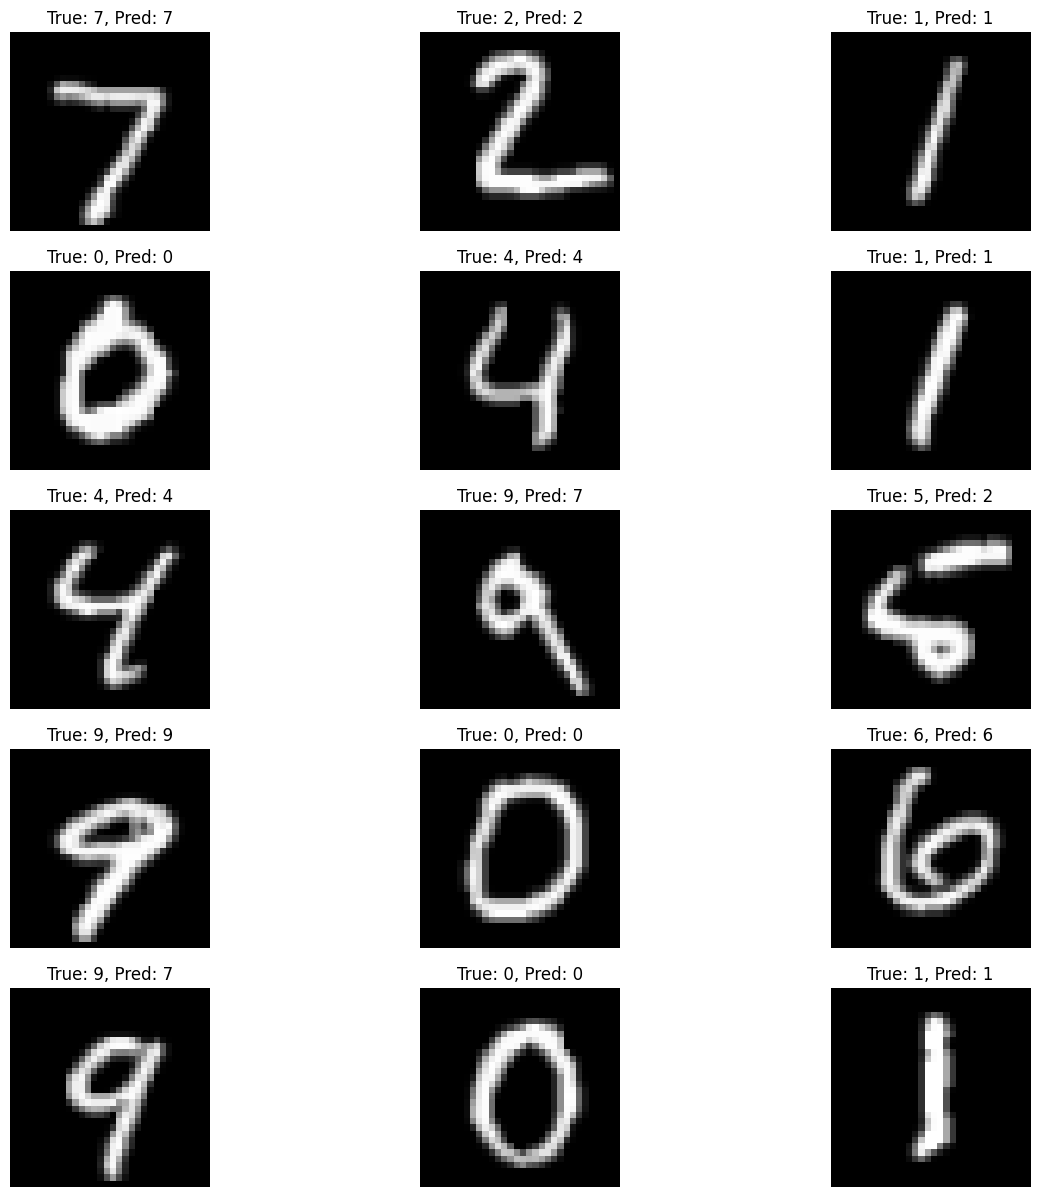

In [13]:
# 예시 이미지 시각화
examples = iter(test_loader)
example_data, example_labels = next(examples)

with torch.no_grad():
    example_data = example_data.to(device)
    output = model_resnet18(example_data)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(15, 15))
for i in range(15):
    plt.subplot(5, 3, i + 1)
    plt.imshow(example_data[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
    plt.title(f"True: {example_labels[i]}, Pred: {preds[i].item()}")
    plt.axis('off')
plt.show()